The goal of this notebook it to examine the mean reversion properties of volatility by considering the VIX. 

A simple standard deviation band around a monthly average will serve as the measure of volatility. The strategy is long vol only as short vol strategies have left tails that I seek to avoid.

If there is a daily close on the VIX 1 standard deviation below the 21 day average the strategy buys 1 unit of vol and holds until the vix closes 1sd above the 21 day average else the startegy is not invested.

C:\Users\Seb Usai\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


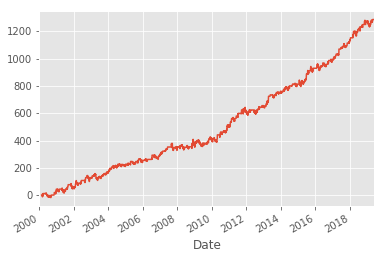

In [8]:
#libraries
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import matplotlib.dates as mdates
style.use ('ggplot')
import numpy as np


#import our data and select dates
start = dt.datetime(2000,1,1)
end = dt.datetime(2019,6,6)
df = web.DataReader('^VIX','yahoo',start,end)
df.to_csv('VIX.csv')
df = pd.read_csv('VIX.csv', parse_dates = True, index_col=0)

#approx 21 trading days per month used for window
window = 21
upper_std = 1
lower_std = 1
#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df['Close'].rolling(window).mean()
rolling_std = df['Close'].rolling(window).std()
#create two new DataFrame columns to hold values of upper and lower Bollinger bands and 200ma for trend
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * upper_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * lower_std)

#Create an "empty" column as placeholder for our /position signals
df['Position'] = None
#Fill our newly created position column - we will buy (1 unit) for a lower band break and go to 0 on an upper band break

for row in range(len(df)):
    
    if (df['Close'].iloc[row] > df['Bollinger High'].iloc[row]) and (df['Close'].iloc[row-1] < df['Bollinger High'].iloc[row-1]):
        df['Position'].iloc[row] = 0
        
    if (df['Close'].iloc[row] < df['Bollinger Low'].iloc[row]) and (df['Close'].iloc[row-1] > df['Bollinger Low'].iloc[row-1]):
        df['Position'].iloc[row] = 1
#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
df['Position'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))*100
df['Strategy Return'] = df['Market Return'] * df['Position'].shift(1)

#Plot the strategy returns
df['Strategy Return'].cumsum().plot()



a suprisingly smooth strategy with a right tail and inverse correlation with the S&P500. This could be impemented with VIX call options to precisely limit risk. Furthermore short vix strategies could be implemented with vix puts to remove the left tail and gain additional trading opportunities. 